Welcome to the example docs for diff_classifier.  This example will walk you through using diff_classifier to track particle trajectories from a video collected via fluorescence microscopy, or some other imaging technique.  

# Loading and checking video

In order to properly track the video, the user must enter the following relevant information regarding the video to be tracked:
* **prefix**: the name of the file to be tracked, minus the file extension.  Typically tif files are the best to track.
* **local_folder**: the location of the video to be tracked.
* **ires**: the desired resolution of sub-videos to be tracked.  Since the images to be tracked may be too large to analyze all at once, the user may need to crop images to perform correctly.  512 x 512 pixels is the standard size.
* **frames**: number of frames contained in the video.  

In [15]:
import os.path as op

In [16]:
prefix = 'example_video'
local_folder = '../diff_classifier/data'
ires = 512
frames = 651

filename = '{}.tif'.format(prefix)
local_name = op.join(local_folder, filename)

In [23]:
import skimage.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
example = sio.imread(local_name)

(-0.5, 2047.5, 2043.5, -0.5)

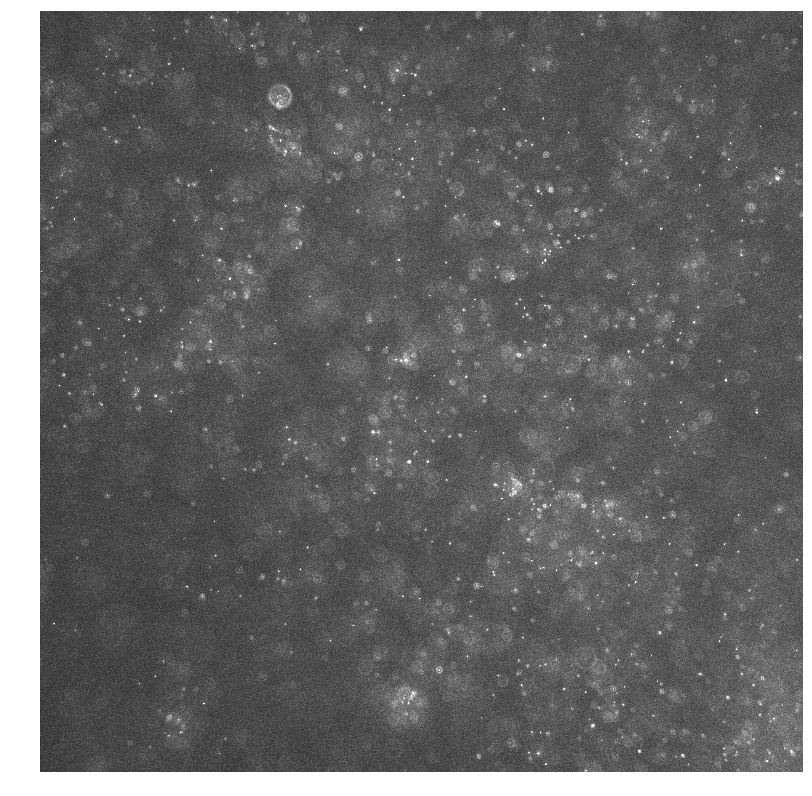

In [24]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(example[650, :, :], cmap='gray', vmin=60, vmax=500)
ax.axis('off')

In [ ]:
names = ij.partition_im(local_name)
for name in names:
    #aws.upload_s3(name, op.join(remote_folder, name))
    print("Done with splitting.  Should output file of name {}".format(local_folder+'/'+name))

In [ ]:
names = []
for i in range(0, 4):
    for j in range(0, 4):
        names.append('{}_{}_{}.tif'.format(prefix, i, j))